## Analyse de sentiment

Nous allons utiliser:
1. `NLTK` et `Torch` pour le prepocessing des phrases de notre datasets
2. `TF-ID` ou `CountVectorizer` de `sklearn` pour encoder les phrases dans un langage comprehensible pour la machine
2. Un model de reseaux de neuronnes recurrents `GRU`: *Gated Recurrent Units*

In [68]:
import pandas as pd

In [69]:
data_path = "data/corpus.csv"

data = pd.read_csv(data_path, encoding='ISO-8859-1')

data.head()


,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [71]:
data["label"].value_counts()

label
__label__1     5097
__label__2     4903
Name: count, dtype: int64

In [72]:
data["label"] = data["label"].map(lambda x: x.strip())
data["label"] = data["label"].apply(lambda x: 0 if x == "__label__1" else 1)

data["label"].value_counts()

label
0    5097
1    4903
Name: count, dtype: int64

In [73]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=92, shuffle=True)

train_data.shape, test_data.shape

((7500, 2), (2500, 2))

In [74]:
from torchtext.data.utils import get_tokenizer

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [75]:
nltk.download("stopwords")

tokenizer = get_tokenizer("basic_english")
stop_words = set(stopwords.words("english"))

threshold = 1

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/josheren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
def preprocess_text(sentence):
    sentence = sentence.lower()
    tokens = tokenizer(sentence)
    #freq_dist = FreqDist(tokens)
    #tokens = [token for token in tokens if freq_dist[token] > threshold]
    stemmer = PorterStemmer()
    stem_tokens = [stemmer.stem(token) for token in tokens]
    sentence = " ".join(stem_tokens)
    return sentence

def encode_sentences(sentences):
    #tf = TfidfVectorizer()
    tf = CountVectorizer()
    X = tf.fit_transform(sentences)
    return X.toarray(), tf

In [77]:
train_data["text"]

2913     Boring and Stupid: Dark Side of the Moon make...
9413     Ry Cooder: As an avid music fan with an abidi...
4420     Shakespeare's best!: I love this play. The wo...
1983     cute costume: cute costume but make sure you ...
3487     It worked fine until I bought a new computer:...
                              ...                        
8573     high school writing!: this is probably one of...
1436     Frida's more attractive soundtrack sister: Ut...
8902     I think that its a good book: Anthony's works...
6162     Not good, not bad: If you like early Mark Har...
4218     California Exotics jack rabbit: Piece of crap...
Name: text, Length: 7500, dtype: object

In [78]:
train_data["text"].apply(lambda x: preprocess_text(x))

2913    bore and stupid dark side of the moon make the...
9413    ry cooder as an avid music fan with an abid in...
4420    shakespear ' s best ! i love thi play . the wo...
1983    cute costum cute costum but make sure you get ...
3487    it work fine until i bought a new comput i own...
                              ...                        
8573    high school write ! thi is probabl one of the ...
1436    frida ' s more attract soundtrack sister utter...
8902    i think that it a good book anthoni ' s work a...
6162    not good , not bad if you like earli mark harm...
4218    california exot jack rabbit piec of crap . all...
Name: text, Length: 7500, dtype: object

In [79]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDatasets(Dataset):
    def __init__(self, X, y):
        super().__init__()
        if hasattr(X, "toarray"):
            X = X.toarray()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        label = self.y[idx]
        return features, label

In [80]:
def text_processing_pipeline(df, tf=None, fit=True):
    text_data = df.copy()
    text_data["text"] = text_data["text"].apply(lambda x: preprocess_text(x))
    
    if fit:
        X, tf = encode_sentences(text_data["text"])
    else:
        X = tf.transform(text_data["text"])
    
    y = text_data["label"].values
    datasets = TextDatasets(X, y)
    data_loader = DataLoader(datasets, batch_size=12, shuffle=True)
    return data_loader, tf

In [81]:
train_dataloader, tf = text_processing_pipeline(train_data, fit=True)
test_dataloader, _ = text_processing_pipeline(test_data, tf=tf, fit=False)


In [82]:
features, label = next(iter(train_dataloader))

features.shape, label.shape

(torch.Size([12, 19975]), torch.Size([12]))

In [83]:
input_size = features.shape[0]

In [84]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def  __init__(self, input_size, hidden_size, num_layers=1, num_classes=2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out
        

In [86]:
import torch.optim as optim
from torchmetrics import Accuracy

In [87]:
df_log = pd.DataFrame(columns=["epoch", "train_loss", "test_loss", "test_accuracy"])

In [88]:
input_size = features.shape[1]
hidden_size = 64
num_classes = 2

num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
input_size

Using device: cuda


19975

In [89]:

criterion = nn.CrossEntropyLoss()
acc = Accuracy(task="multiclass", num_classes=2).to(device)

In [90]:
best_acc = 0
patience = 5
trigger = 0

model = GRUModel(input_size, hidden_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):

    # ----- Entrainement -------
    total_loss = 0
    model.train()
    for features, labels in train_dataloader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

    # ------ Evaluation -------
    model.eval()
    acc.reset()
    total_test_loss = 0

    with torch.no_grad():
        for features_test, labels_test in test_dataloader:
            features_test = features_test.to(device)
            labels_test = labels_test.to(device)

            outputs = model(features_test)
            loss_test = criterion(outputs, labels_test)
            total_test_loss += loss_test.item()

            _, predicted = torch.max(outputs.data, 1)
            acc.update(predicted, labels_test)
        
        avg_loss_test = total_test_loss / len(test_dataloader)
        accuracy = acc.compute().item() * 100

        df_log.loc[epoch] = [epoch+1, avg_loss, avg_loss_test, accuracy]
        print(f"Epoch {epoch+1}, Test Loss: {avg_loss_test:.4f}, Accuracy: {accuracy:.2f}%")

    if accuracy > best_acc:
        best_acc = accuracy
        best_model = model
        trigger = 0
        torch.save(model.state_dict(), "models/best_model.pth")
    else:
        trigger += 1
        if trigger >= patience:
            print("--- Early stopping: no improvement. ---")
            break


Epoch 1, Train Loss: 0.4364
Epoch 1, Test Loss: 0.3280, Accuracy: 86.84%
Epoch 2, Train Loss: 0.1967
Epoch 2, Test Loss: 0.3232, Accuracy: 86.56%
Epoch 3, Train Loss: 0.0985
Epoch 3, Test Loss: 0.3758, Accuracy: 86.00%
Epoch 4, Train Loss: 0.0491
Epoch 4, Test Loss: 0.4295, Accuracy: 85.44%
Epoch 5, Train Loss: 0.0237
Epoch 5, Test Loss: 0.5016, Accuracy: 85.08%
Epoch 6, Train Loss: 0.0121
Epoch 6, Test Loss: 0.5830, Accuracy: 84.24%
--- Early stopping: no improvement. ---


<Figure size 640x480 with 0 Axes>

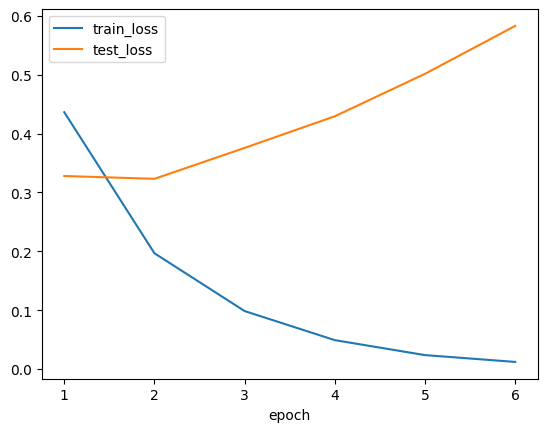

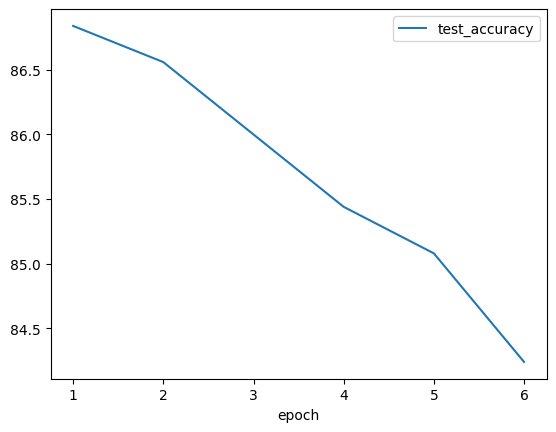

In [91]:
import matplotlib.pyplot as plt

plt.figure()
df_log.plot(x="epoch", y=["train_loss", "test_loss"])
df_log.plot(x="epoch", y="test_accuracy")
plt.show()

In [102]:
sentences = [
    "I love this product, it's amazing!",
    "I am extremely satisfied with my purchase.",
    "The experience exceeded my expectations.",
    "This is an excellent idea, great job to the team!",
    "I will definitely recommend this service to my friends.",
    "Everything worked perfectly from start to finish.",
    "I hate this product, it doesn't work.",
    "I am very disappointed with the quality.",
    "The experience was a disaster.",
    "This is a terrible idea.",
    "I will never recommend this service.",
    "I regret buying this item.",
]

for text in sentences:
    text_clean = preprocess_text(text)

    X_test = tf.transform([text_clean])

    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        output = best_model(X_test_tensor)
        _, predicted = torch.max(output, 1)
        label = predicted.item()

    # Interprétation du résultat
    if label == 0:
        print(f"{text}: Sentiment Négatif \n")
    else:
        print(f"{text}: Sentiment Positif \n")


I love this product, it's amazing!: Sentiment Positif 

I am extremely satisfied with my purchase.: Sentiment Positif 

The experience exceeded my expectations.: Sentiment Positif 

This is an excellent idea, great job to the team!: Sentiment Positif 

I will definitely recommend this service to my friends.: Sentiment Positif 

Everything worked perfectly from start to finish.: Sentiment Positif 

I hate this product, it doesn't work.: Sentiment Négatif 

I am very disappointed with the quality.: Sentiment Négatif 

The experience was a disaster.: Sentiment Négatif 

This is a terrible idea.: Sentiment Négatif 

I will never recommend this service.: Sentiment Positif 

I regret buying this item.: Sentiment Positif 



## Remarque 

on remarque que le model a un souci de generalisation du à un manque de donnés

In [104]:
sentences = [
    "amazing!",
    "satisfied",
    "excellent idea",
    "definitely recommend",
    "perfectly",
    "hate",
    "disappoint",
    "disaster",
    "terrible idea",
    "never recommend",
    "regret",
]

for text in sentences:
    text_clean = preprocess_text(text)

    X_test = tf.transform([text_clean])

    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        output = best_model(X_test_tensor)
        _, predicted = torch.max(output, 1)
        label = predicted.item()

    # Interprétation du résultat
    if label == 0:
        print(f"{text}: Sentiment Négatif \n")
    else:
        print(f"{text}: Sentiment Positif \n")

amazing!: Sentiment Positif 

satisfied: Sentiment Positif 

excellent idea: Sentiment Positif 

definitely recommend: Sentiment Positif 

perfectly: Sentiment Positif 

hate: Sentiment Négatif 

disappoint: Sentiment Négatif 

disaster: Sentiment Négatif 

terrible idea: Sentiment Négatif 

never recommend: Sentiment Positif 

regret: Sentiment Positif 

